In [1]:
import sys

In [2]:
# py_entitymatching relies on the following packages from the Python eco-system

|S.No|  Package | Comments  |
|---|---|---|
|1|  *pandas*  | provides data structures (such as DataFrame) to <span style="color:red;">store and manage relational data</span>. Specifically, DataFrame is used to represent input tables.  |
|2| *scikit-learn*   | provides implementations for common <span style="color:red;">machine learning</span> algorithms. Specifically, this is used in ML-based matchers.  |
|3| *joblib*  | provides <span style="color:red;">multiprocessing</span> capabilities. Specifically, this is used to parallelize blockers across multiple processors.|
|4| *PyQt4*  | provides tools to <span style="color:red;">build GUI</span>. Specifically, this is used to build GUI for labeling data  and debugging matchers.|
|5|  *py_stringsimjoin* |  provides <span style="color:red;">scalable</span> implementations for <span style="color:red;">string similarity joins</span> over two tables. Specifically,   this is used to scale blockers. |
|6| *py_stringmatching* | provides a comprehensive set of <span style="color:red;"> tokenizers and string similarity functions</span>. Specifically, this is to create features for blocking and matching.|
|7|  *cloudpickle* |provides functions to <span style="color:red;"> serialize Python constructs</span>. Specifically, this is used to load/save objects from/to disk. |
|8| *pyprind*  | library to display <span style="color:red;"> progress indicators</span>. Specifically, this is used to display progress of blocking functions, matching functions, etc.  |
|9| *pyparsing*  | library to <span style="color:red;">parse strings</span>. Specifically, this is used to parse rules/features that are declaratively written by the user.  |
|10|  *six* |  provides functions to <span style="color:red;">write compatible code across Python 2 and 3</span>. |

In [3]:
import py_entitymatching as em
import profiler
import pandas as pd

/Users/pradap/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read input tables

In [4]:
## Read input tables
A = em.read_csv_metadata('dblp_demo.csv', key='id')
B = em.read_csv_metadata('acm_demo.csv', key='id')

No handlers could be found for logger "py_entitymatching.io.parsers"


In [5]:
len(A), len(B), len(A) * len(B)

(1800, 1813, 3263400)

In [6]:
A.head(2)

,id,title,authors,venue,paper year
0,l0,Paradise: A Database System for GIS Applications,Paradise Team,SIGMOD Conference,1995
1,l1,A Query Language and Optimization Techniques for Unstructured Data,"Gerd G. Hillebrand, Peter Buneman, Susan B. Davidson, Dan Suciu",SIGMOD Conference,1996


In [7]:
B.head(2)

,id,title,authors,venue,paper year
0,r0,An efficient bitmap encoding scheme for selection queries,"Chee-Yong Chan, Yannis E. Ioannidis",International Conference on Management of Data,1999
1,r1,Integrating a Structured-Text Retrieval System with an Object-Oriented Database System,"Tak W. Yan, Jurgen Annevelink",Very Large Data Bases,1994


In [8]:
# If the tables are large we can downsample the tables like this
A1, B1 = em.down_sample(A, B, 500, 1, show_progress=False)
len(A1), len(B1)

# But for the demo, we will use the entire table A and B

(481, 500)

## Block tables to get candidate set

Number of unique values: 10
Number of missing values: 0

Unique values:
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

Frequency plot:



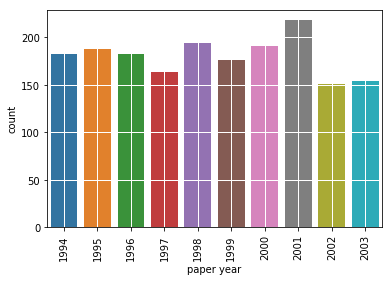

In [9]:
profiler.profile_table(A, 'paper year')

Number of unique values: 11
Number of missing values: 0

Unique values:
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 20003]

Frequency plot:



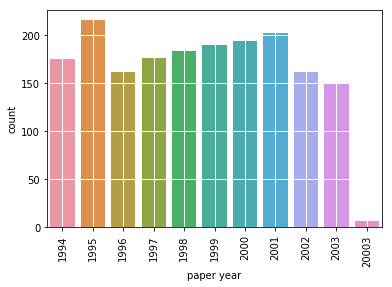

In [10]:
profiler.profile_table(B, 'paper year')

From the plot we can see that 20003 is definitely an error. We will replace 20003 by 2003.

In [11]:
B.replace({'paper year':{
            20003:2003
        }}, inplace=True)

In [12]:
### Blocking plan

### A, B -- AttrEquivalence blocker [year]--------------------------| Candidate set

In [12]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C1 = ab.block_tables(A, B, 'paper year', 'paper year', 
                     l_output_attrs=['title', 'authors', 'paper year'],
                     r_output_attrs=['title', 'authors', 'paper year']
                    )
len(C1)

328781

In [13]:
C1.head(2)

,_id,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_paper year,rtable_title,rtable_authors,rtable_paper year
0,0,l0,r2,Paradise: A Database System for GIS Applications,Paradise Team,1995,Nearest neighbor queries,"Nick Roussopoulos, Stephen Kelley, Frédéric Vincent",1995
1,1,l0,r3,Paradise: A Database System for GIS Applications,Paradise Team,1995,The LyriC language: querying constraint objects,"Alexander Brodsky, Yoram Kornatzky",1995


### Debug blocking output

In [14]:
# check whether the current blocking method has dropped a lot of potential matches
dbg = em.debug_blocker(C1, A, B)

In [15]:
dbg.head()

,_id,similarity,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_venue,rtable_title,rtable_authors,rtable_venue
0,0,0.941176,l239,r821,Workshop Report on Experiences Using Object Data Management in the Real-World,Akmal B. Chaudhri,SIGMOD Record,Workshop report on experiences using object data management in the real-world,Akmal B. Chaudhri,ACM SIGMOD Record
1,1,0.941176,l941,r94,"Some Remarks on Variable Independence, Closure, and Orthographic Dimension in Constraint Databases",Leonid Libkin,SIGMOD Record,"Some remarks on variable independence, closure, and orthographic dimension in constraint databases",Leonid Libkin,ACM SIGMOD Record
2,2,0.928571,l790,r106,Research in database engineering at the University of Namur,Jean-Luc Hainaut,SIGMOD Record,Research in database engineering at the University of Namur,Jean-Luc Hainaut,ACM SIGMOD Record
3,3,0.928571,l1039,r1051,Middle East Technical University Software Research and Development Center,Asuman Dogac,SIGMOD Record,Middle East Technical University Software Research and Development Center,Asuman Dogac,ACM SIGMOD Record
4,4,0.923077,l1207,r148,Database Research at NTHU and ITRI,Arbee L. P. Chen,SIGMOD Record,Database research at NTHU and ITRI,Arbee L. P. Chen,ACM SIGMOD Record


In [16]:
# em.view_table(dbg)

In [17]:
# Revised blocking plan

# A, B -- AttrEquivalence blocker [year] --------------------|
#                                                           |---> candidate set
# A, B -- Overlap blocker [title]---------------------------|

In [18]:
# Profile 'title' column in table A
profiler.profile_table(A, 'title', plot=False)

,Property,Value
0,Num. Missing Values,0
1,Num. Unique Values,1797
2,List of Unique Values,"[1-Safe Algorithms for Symmetric Site Configurations, 3D Geographic Network Displays, 50,000 Use..."


In [19]:
# Profile 'title' column in table B
profiler.profile_table(B, 'title', plot=False)

,Property,Value
0,Num. Missing Values,0
1,Num. Unique Values,1803
2,List of Unique Values,"[1-Safe Algorithms for Symmetric Site Configurations, 2Q: A Low Overhead High Performance Buffer..."


In [22]:
# Initialize overlap blocker
ob = em.OverlapBlocker()
# Block over title attribute
C2 = ob.block_tables(A, B, 'title', 'title', show_progress=False, overlap_size=1, rem_stop_words=True)
len(C2)

476319

In [23]:
# Combine the outputs from attr. equivalence blocker and overlap blocker
C = em.combine_blocker_outputs_via_union([C1, C2])
len(C)

752550

In [24]:
# Check again to see if we are dropping any potential matches
dbg = em.debug_blocker(C, A, B)


In [25]:
dbg.head()

,_id,similarity,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_venue,rtable_title,rtable_authors,rtable_venue
0,0,0.400000,l1686,r1666,SQL/XML is Making Good Progress,"Andrew Eisenberg, Jim Melton",SIGMOD Record,Standards in practice,"Andrew Eisenberg, Jim Melton",ACM SIGMOD Record
1,1,0.400000,l484,r1666,SQL Standardization: The Next Steps,"Andrew Eisenberg, Jim Melton",SIGMOD Record,Standards in practice,"Andrew Eisenberg, Jim Melton",ACM SIGMOD Record
2,2,0.400000,l188,r1666,An Early Look at XQuery,"Andrew Eisenberg, Jim Melton",SIGMOD Record,Standards in practice,"Andrew Eisenberg, Jim Melton",ACM SIGMOD Record
3,3,0.384615,l519,r352,Developments at ACM TODS,Richard T. Snodgrass,SIGMOD Record,Reminiscences in influential papers,Richard Snodgrass,ACM SIGMOD Record
4,4,0.384615,l519,r921,Developments at ACM TODS,Richard T. Snodgrass,SIGMOD Record,Reminiscences on influential papers,Richard Snodgrass,ACM SIGMOD Record


### Match tuple pairs in candidate set

#### 1. Sample candidate set  --> S
#### 2. Label S 
#### 3. Split S into development set (I) and evaluation set (J)
#### 4. Select best learning-based matcher X, using I
#### 5. Compute accuracy of X on J

In [26]:
# Sample  candidate set
S = em.sample_table(C, 450)

In [27]:
# Label S
S = em.label_table(S, 'label')

In [28]:
# Load the pre-labeled data
S = em.read_csv_metadata('labeled_data_demo.csv', 
                         key='_id',
                         ltable=A, rtable=B, 
                         fk_ltable='ltable_id', fk_rtable='rtable_id')
len(S)

450

In [29]:
# Split S into I an J
IJ = em.split_train_test(S, train_proportion=0.5, random_state=0)
I = IJ['train']
J = IJ['test']

### Selecting the best learning-based matcher using I


#### 1. Create a set of ML-matchers
#### 2. Generate a set of features (F)
#### 3. Convert I into a set of feature vectors (H) using F
#### 4. Select best learning-based matcher (X) using k-fold cross validation over H
#### 5. Debug X (and repeat the above steps)

In [30]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree', random_state=0)
svm = em.SVMMatcher(name='SVM', random_state=0)
rf = em.RFMatcher(name='RF', random_state=0)
lg = em.LogRegMatcher(name='LogReg', random_state=0)
ln = em.LinRegMatcher(name='LinReg')

In [35]:
# Generate a set of features
F = em.get_features_for_matching(A, B, validate_inferred_attr_types=False)

In [36]:
# List the feature names generated
F['feature_name']

0                          id_id_lev_dist
1                           id_id_lev_sim
2                               id_id_jar
3                               id_id_jwn
4                               id_id_exm
5                   id_id_jac_qgm_3_qgm_3
6             title_title_jac_qgm_3_qgm_3
7         title_title_cos_dlm_dc0_dlm_dc0
8                         title_title_mel
9                    title_title_lev_dist
10                    title_title_lev_sim
11        authors_authors_jac_qgm_3_qgm_3
12    authors_authors_cos_dlm_dc0_dlm_dc0
13                    authors_authors_mel
14               authors_authors_lev_dist
15                authors_authors_lev_sim
16              paper_year_paper_year_exm
17              paper_year_paper_year_anm
18         paper_year_paper_year_lev_dist
19          paper_year_paper_year_lev_sim
Name: feature_name, dtype: object

In [37]:
# Convert the I into a set of feature vectors using F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='label',
                            show_progress=False) 

In [38]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, ln, lg], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)
result['cv_stats']

TypeError: select_matcher() got an unexpected keyword argument 'metric'

#### Debug X (Random Forest)

In [37]:
# Split H into P and Q
PQ = em.split_train_test(H, train_proportion=0.5, random_state=0)
P = PQ['train']
Q = PQ['test']

In [38]:
# Debug RF matcher using GUI
em.vis_debug_rf(rf, P, Q, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        target_attr='label')

In [39]:
# Add a feature to do Jaccard on title + authors and add it to F

# Create a feature declaratively
sim = em.get_sim_funs_for_matching()
tok = em.get_tokenizers_for_matching()
feature_string = """jaccard(wspace((ltuple['title'] + ' ' + ltuple['authors']).lower()), 
                            wspace((rtuple['title'] + ' ' + rtuple['authors']).lower()))"""
feature = em.get_feature_fn(feature_string, sim, tok)

# Add feature to F
em.add_feature(F, 'jac_ws_title_authors', feature)

True

In [40]:
# Print supported sim. functions
pd.DataFrame({'simfunctions':sorted(sim.keys())})

,simfunctions
0,abs_norm
1,affine
2,cosine
3,dice
4,exact_match
5,hamming_dist
6,hamming_sim
7,jaccard
8,jaro
9,jaro_winkler


In [41]:
# Print supported tokenizers
pd.DataFrame({'tokenizers':sorted(tok.keys())})

,tokenizers
0,alphabetic
1,alphanumeric
2,dlm_dc0
3,qgm_2
4,qgm_3
5,wspace


In [42]:
F['feature_name']

0                          id_id_lev_dist
1                           id_id_lev_sim
2                               id_id_jar
3                               id_id_jwn
4                               id_id_exm
5                   id_id_jac_qgm_3_qgm_3
6             title_title_jac_qgm_3_qgm_3
7         title_title_cos_dlm_dc0_dlm_dc0
8                         title_title_mel
9                    title_title_lev_dist
10                    title_title_lev_sim
11        authors_authors_jac_qgm_3_qgm_3
12    authors_authors_cos_dlm_dc0_dlm_dc0
13                    authors_authors_mel
14               authors_authors_lev_dist
15                authors_authors_lev_sim
16              paper_year_paper_year_exm
17              paper_year_paper_year_anm
18         paper_year_paper_year_lev_dist
19          paper_year_paper_year_lev_sim
20                   jac_ws_title_authors
Name: feature_name, dtype: object

In [43]:
# Convert I into feature vectors using updated F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='label',
                            show_progress=False) 

In [44]:
# Check whether the updated F improves X (Random Forest)
result = em.select_matcher([rf], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x1118e97f0>,5,0.974359,1.0,0.962963,0.933333,1.0,0.974131


In [45]:
# Select the best matcher again using CV
result = em.select_matcher([dt, rf, svm, ln, lg], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x1118e9dd8>,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x1118e97f0>,5,0.974359,1.000000,0.962963,0.933333,1.000000,0.974131
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x1118e92e8>,5,0.947368,0.960000,0.782609,0.933333,0.916667,0.907995
3,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x1118e9710>,5,1.000000,1.000000,0.962963,1.000000,0.960000,0.984593
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x1118e9470>,5,0.974359,0.962963,0.962963,0.933333,0.960000,0.958724


### Compute accuracy of X (Decision Tree) on J

#### 1. Train X using  H
#### 2. Convert J into a set of feature vectors (L)
#### 3. Predict on L using X
#### 4. Evaluate the predictions

In [46]:
# Train using feature vectors from I 
dt.fit(table=H, 
       exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'], 
       target_attr='label')

# Convert J into a set of feature vectors using F
L = em.extract_feature_vecs(J, feature_table=F,
                            attrs_after='label', show_progress=False)

# Predict on L 
predictions = dt.predict(table=L, exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'], 
              append=True, target_attr='predicted', inplace=False)

In [47]:
# Evaluate the predictions
eval_result = em.eval_matches(predictions, 'label', 'predicted')
em.print_eval_summary(eval_result)

Precision : 100.0% (73/73)
Recall : 100.0% (73/73)
F1 : 100.0%
False positives : 0 (out of 73 positive predictions)
False negatives : 0 (out of 152 negative predictions)
